<a href="https://colab.research.google.com/github/MarkusNeusinger/defichain-data-toolkit/blob/main/notebooks/usdToPeg_NI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install gspread google-auth

import os, sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import concurrent.futures
from google.colab import files
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, DayLocator, WeekdayLocator
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default

# import defichain-data-toolkit utils, style
if os.path.isdir('defichain-data-toolkit'): os.system('rm -rf defichain-data-toolkit')
!git clone https://github.com/MarkusNeusinger/defichain-data-toolkit.git
sys.path.insert(1, 'defichain-data-toolkit')

from utils import fetch_history
plt.style.use('/content/defichain-data-toolkit/utils/defichain.mplstyle')

print(f"\nNotebook last run: {datetime.utcnow()}")

Cloning into 'defichain-data-toolkit'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 84 (delta 29), reused 30 (delta 9), pack-reused 0
Receiving objects: 100% (84/84), 3.35 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (29/29), done.

Notebook last run: 2024-02-16 20:36:37.986332


In [9]:
# functions
def calculate_pool_balance_and_costs(start_token1, start_token2, step_size, target_ratio):
    token1 = start_token1  # This is the token being added to the pool
    token2 = start_token2  # This is the token being purchased
    k = token1 * token2  # Constant k from the Uniswap formula x*y=k

    number_of_steps = 0
    total_costs_token1 = 0
    total_purchased_token2 = 0

    while token1 / token2 < target_ratio:
        token1_old = token1
        token1 += step_size
        token2_old = token2
        token2 = k / token1

        cost_token1 = token1 - token1_old
        purchased_token2 = token2_old - token2
        total_costs_token1 += cost_token1
        total_purchased_token2 += purchased_token2

        number_of_steps += 1

    return number_of_steps, total_costs_token1, total_purchased_token2, token1, token2

def calculate_for_row(row):
    swap_step_size = 10  # use higher number for quicker calculation

    # For DUSDT-DUSD
    start_token1_dusdt = row['dusdt-dusddusdtreserve']
    start_token2_dusdt = row['dusdt-dusddusdreserve']
    _, total_costs_token1_dusdt, total_purchased_token2_dusdt, _, _ = calculate_pool_balance_and_costs(start_token1_dusdt, start_token2_dusdt, swap_step_size, 1)

    # For DUSDC-DUSD
    start_token1_dusdc = row['dusdc-dusddusdcreserve']
    start_token2_dusdc = row['dusdc-dusddusdreserve']
    _, total_costs_token1_dusdc, total_purchased_token2_dusdc, _, _ = calculate_pool_balance_and_costs(start_token1_dusdc, start_token2_dusdc, swap_step_size, 1)

    # For DEUROC-DUSD
    start_token1_deuroc = row['deuroc-dusddeurocreserve']
    start_token2_deuroc = row['deuroc-dusddusdreserve']
    _, total_costs_token1_deuroc, total_purchased_token2_deuroc, _, _ = calculate_pool_balance_and_costs(start_token1_deuroc, start_token2_deuroc, swap_step_size, row['usd:euroc'])

    # For DUSD-DFI
    start_token1_dfi = row['dusd-dfidfireserve']
    start_token2_dfi = row['dusd-dfidusdreserve']
    _, total_costs_token1_dfi, total_purchased_token2_dfi, _, _ = calculate_pool_balance_and_costs(start_token1_dfi, start_token2_dfi, swap_step_size, row['usd:dfi'])


    return pd.Series([
        total_purchased_token2_dusdt, total_costs_token1_dusdt,
        total_purchased_token2_dusdc, total_costs_token1_dusdc,
        total_purchased_token2_deuroc, total_costs_token1_deuroc,
        total_purchased_token2_dfi, total_costs_token1_dfi,
    ])

def parallel_apply(df, func, num_workers):
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        # Split dataframe into chunks and process each chunk in parallel
        chunks = np.array_split(df, num_workers)
        results = executor.map(func, chunks)
        return pd.concat(results)

def apply_calculations_to_chunk(chunk):
    return chunk.apply(calculate_for_row, axis=1)

def find_closest(df, dfdoc, df_height_col, dfdoc_activation_col):
    closest_indices = []
    for height in df[df_height_col]:
        closest_index = (dfdoc[dfdoc_activation_col] - height).abs().idxmin()
        closest_indices.append(closest_index)
    return closest_indices

In [10]:
# fetching api data
df = fetch_history('hourly', ['dUSDT-DUSD DUSD Reserve', 'dUSDT-DUSD dUSDT Reserve',
                             'dUSDC-DUSD DUSD Reserve', 'dUSDC-DUSD dUSDC Reserve',
                             'dEUROC-DUSD DUSD Reserve', 'dEUROC-DUSD dEUROC Reserve',
                             'DUSD-DFI DUSD Reserve', 'DUSD-DFI DFI Reserve', 'EUROC:USD', 'DFI:USD', 'DUSD:dUSDC', 'Height', 'DUSD:DFI', 'dUSDC:DFI'],
                   from_timestamp='2023-12-01')
df.sort_values('datetime_utc', ascending=True, inplace=True)
df['usd:euroc'] = 1 / df['euroc:usd']
df['usd:dfi'] = 1 / df['dfi:usd']
df['dusd:dusdc via dfi'] = df['dusd:dfi'] / df['dusdc:dfi']
df.dropna(inplace=True)
df.tail()

100%|██████████| 14/14 [00:02<00:00,  4.94it/s]


,datetime_utc,dusd-dfidfireserve,dusdc-dusddusdreserve,euroc:usd,dfi:usd,dusdt-dusddusdreserve,dusd-dfidusdreserve,dusdt-dusddusdtreserve,deuroc-dusddeurocreserve,dusdc-dusddusdcreserve,deuroc-dusddusdreserve,dusd:dfi,height,dusd:dusdc,dusdc:dfi,usd:euroc,usd:dfi,dusd:dusdc via dfi
1860,2024-02-16 16:00:00,1.539107e+07,1.523131e+06,1.076227,0.088983,1.844351e+06,4.378988e+06,576405.622054,105949.390232,473796.158626,358927.569733,3.514757,3.728365e+06,0.311069,11.241039,0.929172,11.238080,0.312672
1861,2024-02-16 17:00:00,1.540216e+07,1.524325e+06,1.076344,0.088545,1.843597e+06,4.375654e+06,576169.917803,105917.466508,473183.082251,359035.746334,3.519968,3.728494e+06,0.310421,11.292959,0.929071,11.293706,0.311696
1862,2024-02-16 18:00:00,1.540147e+07,1.524305e+06,1.076483,0.088375,1.843601e+06,4.376713e+06,576168.833877,104439.669795,473177.959175,364124.722841,3.518961,3.728610e+06,0.310422,11.310779,0.928951,11.315389,0.311116
1863,2024-02-16 19:00:00,1.541664e+07,1.524485e+06,1.076910,0.088645,1.847147e+06,4.372665e+06,575064.257668,104258.266411,473233.898006,364749.556013,3.525685,3.728715e+06,0.310422,11.270460,0.928583,11.280987,0.312825
1864,2024-02-16 20:00:00,1.541143e+07,1.526014e+06,1.076573,0.088295,1.849960e+06,4.374167e+06,574188.283462,104136.673951,473708.664862,364324.162448,3.523284,3.728797e+06,0.310422,11.297764,0.928873,11.325712,0.311857


In [11]:
# add Google Sheet data
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/11yTO43MBi3WQhtrIwUSpnNMaPVIy8zVVEz8TUyI46VI')

worksheet = spreadsheet.get_worksheet(1)
data = worksheet.get_all_values()

dfdoc = pd.DataFrame(data)
dfdoc.columns = dfdoc.iloc[21]
dfdoc = dfdoc.iloc[22:]
dfdoc['Activating block #'] = [x.replace(',','') for x in dfdoc['Activating block #']]
dfdoc['Activating block #'] = pd.to_numeric(dfdoc['Activating block #'])

worksheet2 = spreadsheet.get_worksheet(0)
data2 = worksheet2.get_all_values()

dfdoc2 = pd.DataFrame(data2)
dfdoc2.columns = dfdoc2.iloc[17]
dfdoc2 = dfdoc2.iloc[18:]
dfdoc2['Activating block #'] = [x.replace(',','') for x in dfdoc2['Activating block #']]
dfdoc2['Activating block #'] = pd.to_numeric(dfdoc2['Activating block #'])

In [12]:
# simulate swaps, calculate buy needed
num_workers = 8
df[['dusdt_dusd_buy_needed', 'dusdt_dusd_token1_cost',
    'dusdc_dusd_buy_needed', 'dusdc_dusd_token1_cost',
    'deuroc_dusd_buy_needed', 'deuroc_dusd_token1_cost',
    'dfi_dusd_buy_needed', 'dfi_dusd_token1_cost']] = parallel_apply(df, apply_calculations_to_chunk, num_workers)

df['dusd_buy_needed'] = df['dfi_dusd_buy_needed'] + df['dusdc_dusd_buy_needed'] + df['dusdt_dusd_buy_needed'] + df['deuroc_dusd_buy_needed']
df['usd_buy_needed'] = df['dfi_dusd_token1_cost'] * df['dfi:usd'] + df['dusdc_dusd_token1_cost'] + df['dusdt_dusd_token1_cost'] + df['deuroc_dusd_token1_cost'] * df['euroc:usd']

df.tail()

,datetime_utc,dusd-dfidfireserve,dusdc-dusddusdreserve,euroc:usd,dfi:usd,dusdt-dusddusdreserve,dusd-dfidusdreserve,dusdt-dusddusdtreserve,deuroc-dusddeurocreserve,dusdc-dusddusdcreserve,...,dusdt_dusd_buy_needed,dusdt_dusd_token1_cost,dusdc_dusd_buy_needed,dusdc_dusd_token1_cost,deuroc_dusd_buy_needed,deuroc_dusd_token1_cost,dfi_dusd_buy_needed,dfi_dusd_token1_cost,dusd_buy_needed,usd_buy_needed
1860,2024-02-16 16:00:00,1.539107e+07,1.523131e+06,1.076227,0.088983,1.844351e+06,4.378988e+06,576405.622054,105949.390232,473796.158626,...,813287.540702,454660.0,673633.211528,375710.0,156627.960698,82030.0,1.930064e+06,12130130.0,3.573613e+06,1.998030e+06
1861,2024-02-16 17:00:00,1.540216e+07,1.524325e+06,1.076344,0.088545,1.843597e+06,4.375654e+06,576169.917803,105917.466508,473183.082251,...,812960.824825,454480.0,675048.345865,376110.0,156723.307144,82050.0,1.932820e+06,12186500.0,3.577552e+06,1.997956e+06
1862,2024-02-16 18:00:00,1.540147e+07,1.524305e+06,1.076483,0.088375,1.843601e+06,4.376713e+06,576168.833877,104439.669795,473177.959175,...,812963.209228,454480.0,675033.390800,376100.0,161799.054472,83520.0,1.935980e+06,12216390.0,3.585776e+06,2.000114e+06
1863,2024-02-16 19:00:00,1.541664e+07,1.524485e+06,1.076910,0.088645,1.847147e+06,4.372665e+06,575064.257668,104258.266411,473233.898006,...,816512.169104,455590.0,675118.730457,376150.0,162384.149444,83660.0,1.928142e+06,12160020.0,3.582157e+06,1.999756e+06
1864,2024-02-16 20:00:00,1.541143e+07,1.526014e+06,1.076573,0.088295,1.849960e+06,4.374167e+06,574188.283462,104136.673951,473708.664862,...,819321.799107,456460.0,675788.667734,376520.0,162224.451635,83590.0,1.934468e+06,12219910.0,3.591802e+06,2.001924e+06


In [13]:
# match dataframes
closest_indices = find_closest(df, dfdoc, 'height', 'Activating block #')

df['DEXFee30'] = dfdoc.loc[closest_indices, 'DEXFee30'].values
df['DEXFee30'] = [x.replace(',','') for x in df['DEXFee30']]
df['DEXFee30'] = pd.to_numeric(df['DEXFee30'])
df['maxDUSDloanslast24h'] = dfdoc.loc[closest_indices, 'max DUSD loans last 24h'].values
df['maxDUSDloanslast24h'] = [x.replace(',','') for x in df['maxDUSDloanslast24h']]
df['maxDUSDloanslast24h'] = pd.to_numeric(df['maxDUSDloanslast24h'])

closest_indices = find_closest(df, dfdoc2, 'height', 'Activating block #')

df['AlgoDUSDratio'] = dfdoc2.loc[closest_indices, 'Algo DUSD ratio'].values
df['AlgoDUSDratio'] = [x.replace('%','') for x in df['AlgoDUSDratio']]
df['AlgoDUSDratio'] = pd.to_numeric(df['AlgoDUSDratio'])

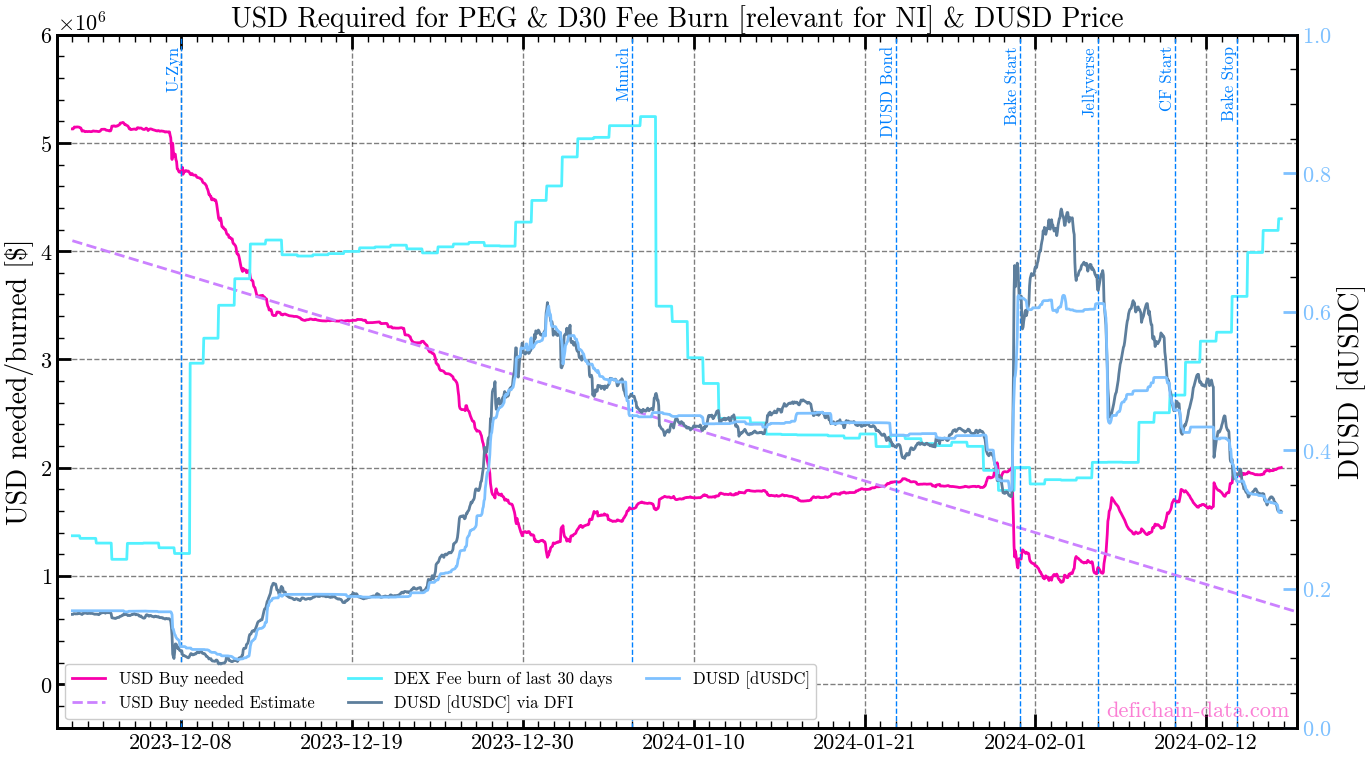

In [20]:
register_matplotlib_converters()

# linear fit
z1 = np.polyfit(pd.to_datetime(df['datetime_utc']).astype('int64'), df['usd_buy_needed'], 1)
p1 = np.poly1d(z1)

zero_crossing = -z1[1]/z1[0]
zero_crossing_date = pd.to_datetime(zero_crossing).strftime('%Y-%m-%d')

min_date = pd.to_datetime(df['datetime_utc']).min()
max_date = pd.to_datetime(zero_crossing)
extended_range = pd.date_range(start=min_date, end=max_date, periods=100).astype('int64')

fig, axs = plt.subplots()

# USD Buy needed
axs.plot(df['datetime_utc'], df['usd_buy_needed'], label='USD Buy needed')
axs.plot(pd.to_datetime(extended_range), p1(extended_range), linestyle='--', label='USD Buy needed Estimate')
axs.scatter(x=max_date, y=0, color='red', marker='d', s=100)

# DEX Fee burn
axs.plot(df['datetime_utc'], df['DEXFee30'], label='DEX Fee burn of last 30 days', color='#52F1FF')
axs.set_title('USD Required for PEG & D30 Fee Burn [relevant for NI] & DUSD Price')
axs.set_ylabel('USD needed/burned [$]')

# DUSD Price
ax2 = axs.twinx()
ax2.plot(df['datetime_utc'], df['dusd:dusdc via dfi'], label='DUSD [dUSDC] via DFI', color='#5d7e9c')
ax2.plot(df['datetime_utc'], df['dusd:dusdc'], label='DUSD [dUSDC]', color='#7EC1FF')
ax2.set_ylabel('DUSD [dUSDC]')
ax2.set_ylim([0,1])
ax2.tick_params(axis='y', colors='#7EC1FF')
ax2.grid(False)

# legend
handles1, labels1 = axs.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
axs.legend(handles, labels, ncol=3, loc='lower left', fontsize="12")

# axis
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs.xaxis.set_major_locator(mdates.DayLocator(interval=11))
axs.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

axs.set_ylim([-400000, 6000000])
# axs.set_xlim(min_date - pd.Timedelta(days=1), max_date + pd.Timedelta(days=5))
axs.set_xlim(min_date - pd.Timedelta(days=1), pd.to_datetime(df['datetime_utc']).max() + pd.Timedelta(days=1))

# annotation
axs.annotate(f"PEG\n{zero_crossing_date}", xy=(max_date, 0), xytext=(0,30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->'), fontsize=16, ha='center')
axs.text(0.92, 0.025, 'defichain-data.com', ha='center', va='center', transform=axs.transAxes,
         fontsize=16, color='#F800AB', alpha=0.5)

# events
events = {
    "U-Zyn": pd.to_datetime("2023-12-08"),
    "Munich": pd.to_datetime("2024-01-06"),
    "DUSD Bond": pd.to_datetime("2024-01-23"),
    "Bake Start": pd.to_datetime("2024-01-31"),
    "Jellyverse": pd.to_datetime("2024-02-05"),
    "Bake Stop": pd.to_datetime("2024-02-14"),
    "CF Start": pd.to_datetime("2024-02-10"),
}

for name, date in events.items():
    axs.axvline(date, color="#0080FF", linestyle='--', linewidth=1)
    axs.annotate(name, xy=(date, 0), xytext=(0, 460),
                textcoords='offset points', fontsize=12, ha='right', va='top', rotation=90, color="#0080FF")

plt.savefig('USD_Buy_needed_estimate.png')
plt.show()